# Survival Analyses 
Comparison of using scikit-surv and pymc-BART

Objectives:
- Comparison of model using scikit-surv cph, randomForest and pymc-BART
- Use the same validation metrics for each model
- Test on multiple datasets
- Extend to R-BART


## Imports

In [1]:
import sksurv as sks
import sksurv.preprocessing
import sksurv.metrics
import sksurv.datasets

from pathlib import Path
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import pandas as pd
import importlib
import numpy as np
import sklearn as skl
import scipy.stats as sp

In [2]:
from sklearn import set_config
set_config(display="text")

## Dataset

In [3]:
# get lung dataset
data_x, data_y = sks.datasets.load_veterans_lung_cancer()
print(data_x)
print(data_y)


     Age_in_years  Celltype  Karnofsky_score  Months_from_Diagnosis  \
0            69.0  squamous             60.0                    7.0   
1            64.0  squamous             70.0                    5.0   
2            38.0  squamous             60.0                    3.0   
3            63.0  squamous             60.0                    9.0   
4            65.0  squamous             70.0                   11.0   
..            ...       ...              ...                    ...   
132          65.0     large             75.0                    1.0   
133          64.0     large             60.0                    5.0   
134          67.0     large             70.0                   18.0   
135          65.0     large             80.0                    4.0   
136          37.0     large             30.0                    3.0   

    Prior_therapy Treatment  
0              no  standard  
1             yes  standard  
2              no  standard  
3             yes  standard

In [4]:
# onehotencode the data_x
data_x_n = sks.preprocessing.OneHotEncoder().fit_transform(data_x)
data_x_n.head()

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
0,69.0,0.0,0.0,1.0,60.0,7.0,0.0,0.0
1,64.0,0.0,0.0,1.0,70.0,5.0,1.0,0.0
2,38.0,0.0,0.0,1.0,60.0,3.0,0.0,0.0
3,63.0,0.0,0.0,1.0,60.0,9.0,1.0,0.0
4,65.0,0.0,0.0,1.0,70.0,11.0,1.0,0.0


## COX Model

In [197]:
# load and fit cox model
cph = sks.linear_model.CoxPHSurvivalAnalysis()
cph.fit(data_x_n, data_y)

CoxPHSurvivalAnalysis()

In [198]:
# show the coef
pd.Series(cph.coef_, index = data_x_n.columns)

Age_in_years            -0.008549
Celltype=large          -0.788672
Celltype=smallcell      -0.331813
Celltype=squamous       -1.188299
Karnofsky_score         -0.032622
Months_from_Diagnosis   -0.000092
Prior_therapy=yes        0.072327
Treatment=test           0.289936
dtype: float64

In [26]:
# create predictions for synthetic patients (over the variable combinations of celltype and treatment)
# Prediction matrix for all combinations of treatment, celltype with age 65, karnofsky=60, months from diagnosis=1 and prior therapy 0 held constant
x_new = pd.DataFrame.from_dict(
    {
        1: [65,0,0,1,60,1,0,1],
        2: [65,0,0,1,60,1,0,0],
        3: [65,0,1,0,60,1,0,0],
        4: [65,0,1,0,60,1,0,1]
    },
    columns=data_x_n.columns,
    orient = "index"
)
x_new

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
1,65,0,0,1,60,1,0,1
2,65,0,0,1,60,1,0,0
3,65,0,1,0,60,1,0,0
4,65,0,1,0,60,1,0,1


In [28]:
# get predictions
# predictions are returned as an array with step functions
pred_surv = cph.predict_survival_function(x_new)
pred_surv

array([StepFunction(x=array([  1.,   2.,   3.,   4.,   7.,   8.,  10.,  11.,  12.,  13.,  15.,
               16.,  18.,  19.,  20.,  21.,  22.,  24.,  25.,  27.,  29.,  30.,
               31.,  33.,  35.,  36.,  42.,  43.,  44.,  45.,  48.,  49.,  51.,
               52.,  53.,  54.,  56.,  59.,  61.,  63.,  72.,  73.,  80.,  82.,
               83.,  84.,  87.,  90.,  92.,  95.,  97.,  99., 100., 103., 105.,
              110., 111., 112., 117., 118., 122., 123., 126., 132., 133., 139.,
              140., 143., 144., 151., 153., 156., 162., 164., 177., 182., 186.,
              200., 201., 216., 228., 231., 242., 250., 260., 278., 283., 287.,
              314., 340., 357., 378., 384., 389., 392., 411., 467., 553., 587.,
              991., 999.]), y=array([0.99434242, 0.99147904, 0.98857541, 0.98561186, 0.97665739,
              0.96418099, 0.9576397 , 0.95430954, 0.94766847, 0.94093389,
              0.93404319, 0.93054128, 0.91989204, 0.91229923, 0.90441587,
              0.8961

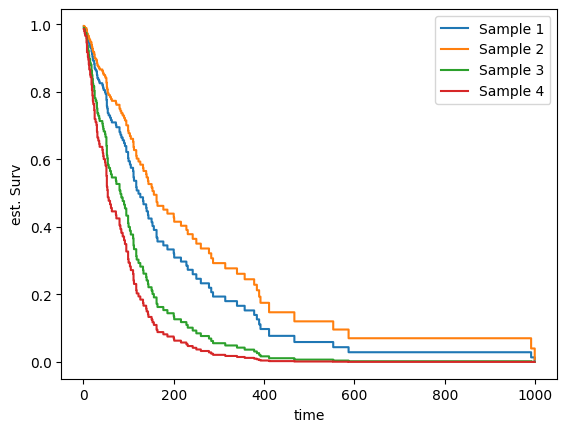

In [29]:
# plot 
time_points = np.arange(1,1000)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post", label=f"Sample {i + 1}")
plt.ylabel("est. Surv")
plt.xlabel("time")
plt.legend(loc="best")

NOTE: this is only for the combination of cell type and test, conditional on the specified other covariates

In [203]:
# get risk scores
cph_risk = cph.predict_survival_function(data_x_n, return_array=True)
cph_surv_mean = np.mean(cph_risk, axis=0)
cph_surv_mean

array([0.98559381, 0.97841596, 0.97121342, 0.96394008, 0.94242868,
       0.91357265, 0.89893774, 0.89161268, 0.87725061, 0.86301109,
       0.84876844, 0.84165331, 0.82050833, 0.80586826, 0.79103582,
       0.77590741, 0.76810426, 0.75278796, 0.72979808, 0.72193682,
       0.71414901, 0.69864098, 0.68350545, 0.67601673, 0.66855574,
       0.66102453, 0.65353012, 0.64615388, 0.63883932, 0.63162186,
       0.62426419, 0.61629386, 0.59256474, 0.56819892, 0.55997253,
       0.54390857, 0.53600842, 0.5282156 , 0.5202698 , 0.51240021,
       0.50451045, 0.49676423, 0.48136646, 0.47314586, 0.47314586,
       0.46491651, 0.4567337 , 0.4484736 , 0.44002348, 0.42346595,
       0.42346595, 0.40671025, 0.39839268, 0.39007727, 0.38161706,
       0.37335694, 0.35753573, 0.34970626, 0.3346586 , 0.32713459,
       0.31977843, 0.31977843, 0.31197086, 0.30430907, 0.29668427,
       0.28918336, 0.28180031, 0.27427284, 0.26695105, 0.25953864,
       0.25195654, 0.24427947, 0.22954044, 0.22222337, 0.21496

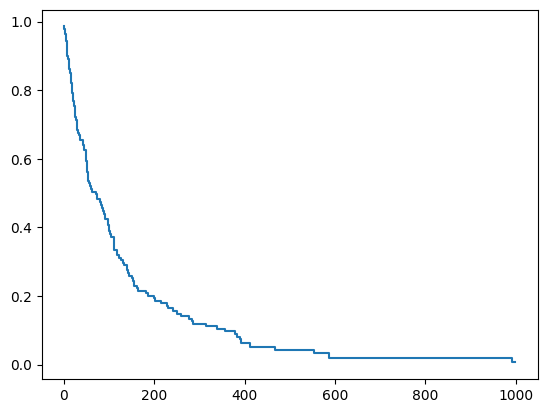

In [204]:
plt.step(np.unique(data_y["Survival_in_days"]), cph_surv_mean)

## Metrics
- Harrell's C-index
    - biased upwards with increasing censoring
- Uno C-index
    - uses ipcw and helps reduce upward bias with increased censoring
    - When dataset is large and censoring is large then using the concordance ipcw will be more stable
- Time-dependent ROC
    - ROC compares the false postive rate (1-specificity) against the true positive rate(sensitivity
    - consider cumulative cases and dynamic controls at time t
        - cumulative cases are individuals who experience event prior to or at time t (t_i <= t)
        - dynamic controls are individuals with t_i > t
    - determins how well a model can identify patients who fail by time t or (t_i < t) from subjects who fail after time t (t_i > t)
    - useful if one is predicting occurence of event in a period up to time t, rather than just at one specific time point t
        eg
        ```
        t ----t1----t2----t3-----t4   
        1 --e--|-----|-----|------| 
        2 -----|-e---|-----|------|
        3 -----|-e---|-----|------| 
        4 -----|-----|-----|---e--|
        ```
        at t2, pats 1,2,3 are cumulative cases and 4 is a dynamic control
    
    - requires that test data time range is within the observed range of the training data
    - the last time point to evaluate the ROC must allow some patients to be censored after the timepoint P(c > t) > 0
    * see the custom auc function for more details
- Brier Score (Time-Dependent)
         

### AUC
sksurv AUC

- will need to implement the time-dependent risk scores

[0.83430233 0.73934426 0.76205534 0.83237548 0.85364281 0.82266886
 0.82988087 0.85316666 0.8412585  0.85657979 0.86779689 0.82499784
 0.80332462 0.79078528 0.79502316]


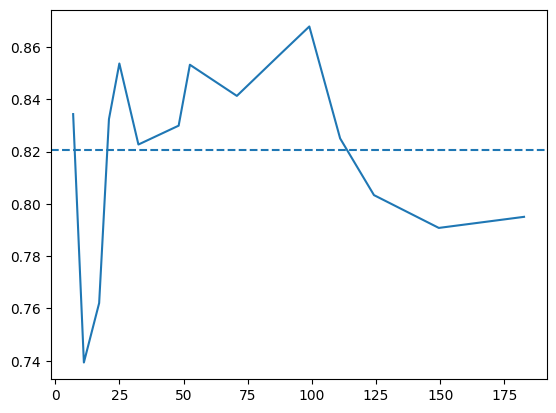

In [133]:

times = np.percentile(data_y["Survival_in_days"], np.linspace(5,81,15))
scores = np.array(data_x_n["Age_in_years"])
cph_auc, cph_auc_mean = sks.metrics.cumulative_dynamic_auc(data_y, data_y, cph_risk, times)

print(cph_auc)
plt.plot(times, cph_auc)
plt.axhline(cph_auc_mean, linestyle="--")

# data_x_n

### IPCW
IPCW is just 1/surv() calculated from the km estimator. 

Easy as fit the km.estimator, get the survival estimates, replace any 0 with infinity and finally inverse with 1/surv



- Required for custom AUC, it is incoporated in the sksurv AUC

- There are two main paths to access the ipcw in sksurv
    - direct with ipc_weights 
    - class censoringDistributionEstimator

- ipc_weights is a little more direct and light-weight

- A custom implementation might be useful for further understanding




In [ ]:
import sksurv.nonparametric

# direct
ipwc = sks.nonparametric.ipc_weights(data_y["Status"], data_y["Survival_in_days"])
print(ipwc)

# class
cde = sks.nonparametric.CensoringDistributionEstimator()
cde.fit(data_y)
ipcw2 = cde.predict_ipcw(data_y)
print(ipcw2)

### AUC Custom
- Requires
    - ipcw of training data
    - time range to calculate on (must not extend to the max censoring date)
    - a risk score (i think this can be either a time dependent or independent risk score)
    - the original times data

In [149]:


# auc_num1 = 0
def get_auc(event, time, hz, w):
    t_out = np.zeros(shape=time.shape)
    for ti in range(0,len(time)):
        #set time
        t = time[ti]
        # print("t", t)

        # get numerator
        auc_num = 0
        pat_rng = range(0, len(hz))
        # sum over patients: sum_rank_ipcw
        # where sum_rank_ipcw: rank_indicator * ipcw weight
        # where rank_indicator: 1 if the other patient has event after time, current patient has event before/at time and other patients hazard is < current patients
            # eg. if time is T = 10, current patient event is 5 and hz is 3, and other patients events are 15,20,1; hz 0,1,4
            # then for current patient iterations we would see
                # iter | ot_pat > t | cur_pat <= t | hz(ot_pat) <= hz(cur_pat) | indicator | weight | out | cumsum
                # 1    | 1          | 1            | 1                         | 1         | 1.3    | 1.3 |  1.3
                # 2    | 1          | 1            | 1                         | 1         | 1.3    | 1.3 |  2.6
                # 3    | 0          | 1            | 0                         | 0         | 1.3    | 0   |  2.6 ***
        # The cumsum for each patient will be added together to form the numerator
        for i in pat_rng:
            auc_num1 = 0
            for j in pat_rng:
                # 1 if iter pat time > t
                i1 = 1 if event[j] > t else 0
                # 1 if hold pat time <= t
                i2 = 1 if event[i] <= t else 0
                # 1 if hz iter pat <= hz hold pat
                i3 = 1 if hz[j] <= hz[i] else 0
                # if iter pat is > t, hold pat <= t and iter pat hz <= hz hold pat then all are 1 and you adjust by the ipcw 
                auc_num1 += i1 * i2 * w[i] * i3 
            # print("auc_num1", auc_num1)
            auc_num += auc_num1

        # denom
        # the denom is the cumsum I(pat_time > t) * cumsum I(pat_time <= t * wi)
        auc_denom = 0
        den_i1 = 0
        for i in pat_rng:
            i1 = 1 if event[i] > t else 0
            den_i1 += i1

        den_i2 = 0
        for i in pat_rng:
            i1 = 1 if event[i] <= t else 0
            # added in w to the equation
            den_i2 += i1 * w[i]

        # eval auc
        # the auc final calc for each timepoint is then ratio of number correctly classified over number expected
        auc = auc_num / (den_i1 * den_i2)
        t_out[ti] = auc

    return t_out



In [150]:
# Implementation
# Requires
    # ipcw of training data
    # time range to calculate on (must not extend to the max censoring date)
    # a risk score (i think this can be either a time dependent or independent risk score)
    # the original times data

# get ipcw
ipcw = sks.nonparametric.ipc_weights(data_y["Status"], data_y["Survival_in_days"])

# get times to quantify
times_cph = np.percentile(data_y["Survival_in_days"], np.linspace(5,81, 15))

# get auc
auc_cust = get_auc(event = data_y["Survival_in_days"], time = times_cph, hz = cph_risk, w = ipcw)

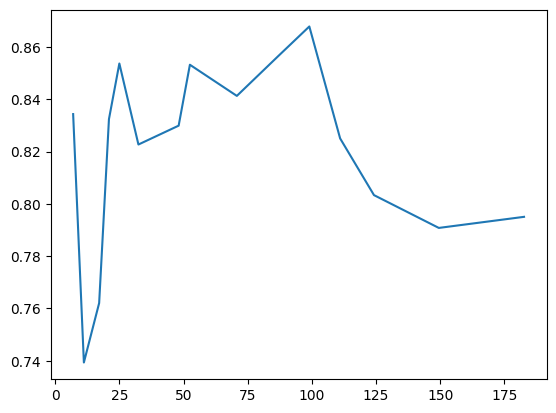

In [151]:
# plot auc
plt.plot(times_cph, auc_cust)

In [153]:
# compare the cust auc and the sksurv auc
print(auc_cust)
print(cph_auc)
# Looks like it works correctly!

[0.83430233 0.73934426 0.76205534 0.83237548 0.85364281 0.82266886
 0.82988087 0.85316666 0.8412585  0.85657979 0.86779689 0.82499784
 0.80332462 0.79078528 0.79502316]
[0.83430233 0.73934426 0.76205534 0.83237548 0.85364281 0.82266886
 0.82988087 0.85316666 0.8412585  0.85657979 0.86779689 0.82499784
 0.80332462 0.79078528 0.79502316]


### C-Index

It would be worth working out these details in a custom function

In [38]:
# get c-index of the trained model on the training dataset

# prediction on train
pred_cph = ecph.predict(data_x_n)

# harrells c-index
h_cindex_cph = sks.metrics.concordance_index_censored(data_y["Status"], data_y["Survival_in_days"], pred_cph)
print("harrels c-index", h_cindex_cph[0])

# uno ipcw c-index
ipcw_cindex_cph = sks.metrics.concordance_index_ipcw(data_y, data_y, pred_cph)
print("ipcw c-index", ipcw_cindex_cph[0])


harrels c-index 0.7362562471603816
ipcw c-index 0.728339023467177


In [ ]:
# # c-index custom
# def c_index(event_indicator, event_time, estimate):
#     order = np.argsort(event_Time)

#     condordant = 0
#     discordant = 0
#     tied_risk = 0
#     numerator = 0.0
#     denominator = 0.0
#     for ind, mask, tied_time in _iter_comparable(event_indicator, event_time, order):
#         est_i = estimate[order[ind]]
#         event_i = event_indicator[order[ind]]
#         w_i = weights[order[ind]]

#         est = estimate[order[mask]]

#         assert event_i, f"got censored sample at index {order[ind]}, but expected uncensored"

#         ties = np.absolute(est - est_i) <= tied_tol
#         n_ties = ties.sum()
#         # an event should have a higher score
#         con = est < est_i
#         n_con = con[~ties].sum()

#         numerator += w_i * n_con + 0.5 * w_i * n_ties
#         denominator += w_i * mask.sum()

#         tied_risk += n_ties
#         concordant += n_con
#         discordant += est.size - n_con - n_ties

#     if tied_time is None:
#         raise NoComparablePairException("Data has no comparable pairs, cannot estimate concordance index.")

#     cindex = numerator / denominator
#     return cindex, concordant, discordant, tied_risk, tied_time


### Brier Score (time-dependent)

- MSE for right censored data
- Depends on the survival probability and ipcw

In [245]:
# Brier score

# get inputs
y_times = data_y["Survival_in_days"]
times = np.percentile(y_times, np.linspace(10,90,10))
print(times)

cph_surv = ecph.predict_survival_function(data_x_n)
cph_surv1 = np.stack([fn(times) for fn in cph_surv])

sks_cph_brier = sks.metrics.brier_score(data_y, data_y, cph_surv1, times)
sks_cph_brier


[ 10.6         19.          26.55555556  44.86666667  55.91111111
  87.13333333 105.66666667 134.33333333 183.24444444 284.6       ]


(array([ 10.6       ,  19.        ,  26.55555556,  44.86666667,
         55.91111111,  87.13333333, 105.66666667, 134.33333333,
        183.24444444, 284.6       ]),
 array([0.08300616, 0.12824397, 0.13882154, 0.17123255, 0.16485628,
        0.15718534, 0.15753888, 0.16624124, 0.14085729, 0.09913274]))

### Custom Brier

In [263]:
# custom brier

def get_brier(y_time, delta, times, surv, ipcw, kipcw, ig = False, ar_out = False):
    t_out = np.zeros(times.shape)
    n = len(y_time)

    for ti, t in enumerate(times):
        # t = times[ti]
        score = 0
        for i in range(0, len(y_time)):
            sv = surv[i](t)
            
            i1 = 1 if y_time[i] <= t and delta[i] == 1 else 0 
            surv_ipcw1 = pow((0 - sv), 2)/ipcw[i] 

            i2 = 1 if y_time[i] > t else 0
            surv_ipcw2 = pow((1 - sv), 2)/kipcw[ti]

            score += (i1 * surv_ipcw1) + (i2 * surv_ipcw2)
        t_out[ti] = score/n
    
    if ig == False:
        return t_out
    else:
        ig_brier = np.trapz(t_out, times)/(times[-1]-times[0])
        if ar_out:
            return ig_brier, t_out
        else:
            return ig_brier


In [256]:
# get inputs
y_times = data_y["Survival_in_days"]
delta = data_y["Status"]
cph_surv = ecph.predict_survival_function(data_x_n)

# get times
times = np.percentile(y_times, np.linspace(10,90,10))

# get the ipcw
cde = sks.nonparametric.CensoringDistributionEstimator()
cde.fit(data_y)

# get the ipcw for patients
# ipcw1 = cde.predict_ipcw(data_y)
ipcw1 = cde.predict_proba(data_y["Survival_in_days"])
ipcw1[ipcw1 ==0] = np.inf


# get the ipcw for times
ipcw2 = cde.predict_proba(times)
ipcw2[ipcw2 == 0] = np.inf
kipcw = ipcw2

cus_cph_brier = get_brier(y_times, delta, times, cph_surv, ipcw1, kipcw)

print(times)
print(cus_cph_brier)
print(sks_cph_brier[0])
print(sks_cph_brier[1])



[ 10.6         19.          26.55555556  44.86666667  55.91111111
  87.13333333 105.66666667 134.33333333 183.24444444 284.6       ]
[0.08300616 0.12824397 0.13882154 0.17123255 0.16485628 0.15718534
 0.15753888 0.16624124 0.14085729 0.09913274]
[ 10.6         19.          26.55555556  44.86666667  55.91111111
  87.13333333 105.66666667 134.33333333 183.24444444 284.6       ]
[0.08300616 0.12824397 0.13882154 0.17123255 0.16485628 0.15718534
 0.15753888 0.16624124 0.14085729 0.09913274]


In [267]:
ig1 = get_brier(y_times, delta, times, cph_surv, ipcw1, kipcw, ig=True)

ig2 = sks.metrics.integrated_brier_score(data_y, data_y, cph_surv1, times)
print(ig1, ig2)

0.14178097156921668 0.1417809715692167


#### Using the kaplain meier estimator as baseline
You need to build the step funciton as seen below

ig_brier is a bit higher on the insample scoring

In [296]:
km_surv = sks.functions.StepFunction(*sks.nonparametric.kaplan_meier_estimator(delta, y_times, conf_type=None))
km_surv = np.tile(km_surv, (len(y_times)))
# cph_surv.shape
# km_surv.shape

get_brier(y_times, delta, times, km_surv, ipcw1, kipcw, ig=True, ar_out=True)

(0.18833158394100705,
 array([0.09174703, 0.15823965, 0.19725142, 0.23008262, 0.24726128,
        0.24927207, 0.24051291, 0.21510274, 0.17297637, 0.1101886 ]))

Success with the brier score custom implementaiton.

## BART-pymc
Run BART on the the dataset used in the cox

In [4]:
data_x, data_y = sks.datasets.load_veterans_lung_cancer()
# print(data_x)
# print(data_y)
data_x_n = sks.preprocessing.OneHotEncoder().fit_transform(data_x)

# full_dtst = pd.concat([pd.DataFrame(data_y), data_x_n], axis=1) 
# full_dtst.to_csv("vet_lung_canc.csv")

### Preprocessing
Data needs to be in a long format

In [5]:
def surv_pre_train(data_x_n, data_y, X_TIME=True):
    # set up times
    t_sort = np.append([0], np.unique(data_y["Survival_in_days"]))
    t_ind = np.arange(0,t_sort.shape[0])
    t_dict = dict(zip(t_sort, t_ind))

    # set up delta
    delta = np.array(data_y["Status"], dtype = "int")
    
    t_out = []
    pat_x_out = []
    delta_out = []
    for idx, t in enumerate(data_y["Survival_in_days"]):
        # get the pat_time and use to get the array of times for the patient
        p_t_ind = t_dict[t]
        p_t_set = t_sort[0:p_t_ind+1]
        t_out.append(p_t_set)
        
        size = p_t_set.shape[0]
        # get patient array
        pat_x = np.tile(data_x_n.iloc[idx].to_numpy(), (size, 1))
        pat_x_out.append(pat_x)

        # get delta
        pat_delta = delta[idx]
        delta_set = np.zeros(shape=size, dtype=int)
        delta_set[-1] = pat_delta
        delta_out.append(delta_set)
    
    
    t_out, delta_out, pat_x_out = np.concatenate(t_out), np.concatenate(delta_out), np.concatenate(pat_x_out)
    if X_TIME:
        pat_x_out = np.array([np.concatenate([np.array([t_out[idx]]), i]) for idx, i in enumerate(pat_x_out)])
    return t_out, delta_out, pat_x_out

def surv_pre_train2(data_x_n, data_y, X_TIME=True):
    # set up times
    # t_sort = np.append([0], np.unique(data_y["Survival_in_days"]))
    t_sort = np.unique(data_y["Survival_in_days"])
    t_ind = np.arange(0,t_sort.shape[0])
    t_dict = dict(zip(t_sort, t_ind))

    # set up delta
    delta = np.array(data_y["Status"], dtype = "int")
    
    t_out = []
    pat_x_out = []
    delta_out = []
    for idx, t in enumerate(data_y["Survival_in_days"]):
        # get the pat_time and use to get the array of times for the patient
        p_t_ind = t_dict[t]
        p_t_set = t_sort[0:p_t_ind+1]
        t_out.append(p_t_set)
        
        size = p_t_set.shape[0]
        # get patient array
        pat_x = np.tile(data_x_n.iloc[idx].to_numpy(), (size, 1))
        pat_x_out.append(pat_x)

        # get delta
        pat_delta = delta[idx]
        delta_set = np.zeros(shape=size, dtype=int)
        delta_set[-1] = pat_delta
        delta_out.append(delta_set)
    
    
    t_out, delta_out, pat_x_out = np.concatenate(t_out), np.concatenate(delta_out), np.concatenate(pat_x_out)
    if X_TIME:
        pat_x_out = np.array([np.concatenate([np.array([t_out[idx]]), i]) for idx, i in enumerate(pat_x_out)])
    return t_out, delta_out, pat_x_out

In [6]:
def surv_pre_test(data_x_n, data_y, X_TIME=True):
    t_sort = np.append([0], np.unique(data_y["Survival_in_days"]))
    t_out = []
    pat_x_out = []
    for idx, t in enumerate(data_y["Survival_in_days"]):
        # get the pat_time and use to get the array of times for the patient
        p_t_set = t_sort
        t_out.append(p_t_set)
        
        size = p_t_set.shape[0]
        # get patient array
        pat_x = np.tile(data_x_n.iloc[idx].to_numpy(), (size, 1))
        pat_x_out.append(pat_x)
    
    t_out, pat_x_out = np.concatenate(t_out),  np.concatenate(pat_x_out)
    if X_TIME:
        pat_x_out = np.array([np.concatenate([np.array([t_out[idx]]), i]) for idx, i in enumerate(pat_x_out)])
    return t_out, pat_x_out
    
def surv_pre_test2(data_x_n, data_y, X_TIME=True):
    # t_sort = np.append([0], np.unique(data_y["Survival_in_days"]))
    t_sort = np.unique(data_y["Survival_in_days"])
    t_out = []
    pat_x_out = []
    for idx, t in enumerate(data_y["Survival_in_days"]):
        # get the pat_time and use to get the array of times for the patient
        p_t_set = t_sort
        t_out.append(p_t_set)
        
        size = p_t_set.shape[0]
        # get patient array
        pat_x = np.tile(data_x_n.iloc[idx].to_numpy(), (size, 1))
        pat_x_out.append(pat_x)
    
    t_out, pat_x_out = np.concatenate(t_out),  np.concatenate(pat_x_out)
    if X_TIME:
        pat_x_out = np.array([np.concatenate([np.array([t_out[idx]]), i]) for idx, i in enumerate(pat_x_out)])
    return t_out, pat_x_out

In [7]:
# # get train dataset
# t1, delta1, trainx1 = surv_pre_train(data_x_n=data_x_n, data_y=data_y)

# # get test dataset
# t_test, testx = surv_pre_test(data_x_n=data_x_n, data_y=data_y)

# get train dataset 2
t2, delta2, trainx2 = surv_pre_train2(data_x_n=data_x_n, data_y=data_y)

# get test dataset 2
t_test2, testx2 = surv_pre_test2(data_x_n=data_x_n, data_y=data_y)

In [8]:
# # check
# print(t1.shape)
# print(delta1.shape)
# print(trainx1.shape)
# print(testx.shape)
# print(t_test.shape)

# check pre2
print(t2.shape)
print(delta2.shape)
print(trainx2.shape)
print(testx2.shape)
print(t_test2.shape)

(6148,)
(6148,)
(6148, 9)
(13837, 9)
(13837,)


Preprocessing is successful.
It is comparable to BART::surv.pre.bart with the minor addition of having added the 0 day into the data, where in BART::surv.pre.bart I belevie the 0 day is added in the model

## Models

### BART1 Model
With 0 day padding

In [234]:
with pm.Model() as bart1:
    x_data = pm.MutableData("x", trainx1)
    # y_data = pm.MutableData("y", delta1)
    
    z = pmb.BART("z", X = x_data, Y = delta1)
    mu = pm.Deterministic("mu", pm.math.invprobit(z))
    y_pred = pm.Bernoulli("y_pred", p=mu, observed=delta1, shape=x_data.shape[0])
    smp1 = pm.sample(random_seed=2)


Multiprocess sampling (4 chains in 4 jobs)
PGBART: [z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 379 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [235]:
with bart1:
    pm.set_data({"x":testx})
    pp1 = pm.sample_posterior_predictive(smp1, var_names= ["y_pred", "z", "mu"])

Sampling: [y_pred, z]


In [238]:
# get the predicted mean
def get_pred_mean(pp1, t_test):
    # get the pp
    # np.mean(pp1.posterior_predictive["mu"][3][:,1])
    rr1 = pp1.posterior_predictive["mu"].mean(("draw", "chain")).values
    # print(rr1.shape)
    # print(pp1.posterior_predictive["mu"].mean(("chain", "draw")))

    K = np.unique(t_test).shape[0]
    N = int(t_test.shape[0]/K)
    rr2 = np.cumprod(1-rr1.reshape((N,K)), axis=1)
    rr2_mean = np.mean(rr2, axis=0)

    return rr2_mean

In [241]:
bart_1_rr = get_pred_mean(pp1, t_test=t_test)
bart_1_rr

array([0.98754375, 0.97499308, 0.96227993, 0.94926395, 0.93570832,
       0.92112744, 0.90637781, 0.89190319, 0.87744136, 0.86310453,
       0.84869819, 0.8344629 , 0.82031082, 0.80621665, 0.79238157,
       0.77859723, 0.7650192 , 0.75159837, 0.73839858, 0.72528631,
       0.71240315, 0.69979693, 0.68734565, 0.67495874, 0.66285417,
       0.6510434 , 0.63938116, 0.62777905, 0.61620715, 0.60467436,
       0.59322587, 0.58186618, 0.57034694, 0.55888611, 0.54753353,
       0.53639079, 0.52554065, 0.51484387, 0.50434709, 0.49395721,
       0.48362136, 0.47329942, 0.46306875, 0.45288489, 0.44287511,
       0.43296508, 0.42310514, 0.41327107, 0.40346172, 0.39365048,
       0.38384284, 0.37406046, 0.36426628, 0.3544348 , 0.34468333,
       0.33494469, 0.3253867 , 0.31586119, 0.30645143, 0.29712414,
       0.28800908, 0.27904383, 0.27021729, 0.26149513, 0.25282356,
       0.24418003, 0.23556938, 0.22711382, 0.21882011, 0.21068181,
       0.20268087, 0.1948111 , 0.18709116, 0.17951699, 0.17214

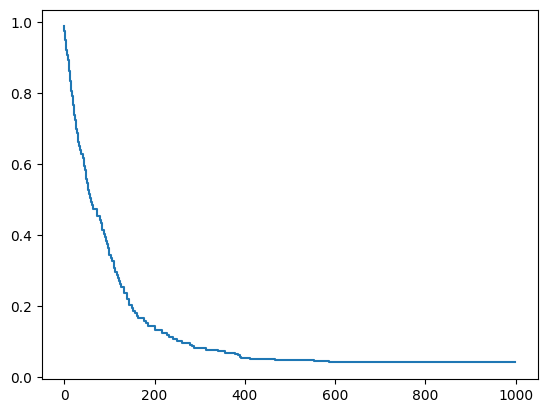

In [242]:
ax = plt.step(np.unique(t_test), bart_1_rr)

### BART2 Model
No 0 day padding

In [222]:
with pm.Model() as bart2:
    x_data = pm.MutableData("x", trainx2)
    # y_data = pm.MutableData("y", delta1)
    
    z = pmb.BART("z", X = x_data, Y = delta2)
    mu = pm.Deterministic("mu", pm.math.invprobit(z))
    y_pred = pm.Bernoulli("y_pred", p=mu, observed=delta2, shape=x_data.shape[0])
    smp2 = pm.sample(random_seed=2)


Multiprocess sampling (4 chains in 4 jobs)
PGBART: [z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 374 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [223]:
# Get test results
with bart2:
    pm.set_data({"x":testx2})
    pp2 = pm.sample_posterior_predictive(smp2, var_names= ["y_pred", "z", "mu"])

Sampling: [y_pred, z]


In [342]:
# look at first patient
np.mean(pp2.posterior_predictive["z"].values[0], 0)[0:101]

array([-2.47558268, -2.47824939, -2.47168593, -2.45355997, -2.43459374,
       -2.41434104, -2.4201707 , -2.41205693, -2.41018376, -2.40926408,
       -2.40814939, -2.4035531 , -2.39660727, -2.38435481, -2.38192938,
       -2.37722326, -2.36321706, -2.35664884, -2.35204981, -2.35269571,
       -2.34949353, -2.34596035, -2.34107296, -2.34155446, -2.33846753,
       -2.33234921, -2.32586664, -2.31450173, -2.31121588, -2.30174738,
       -2.30058175, -2.29020536, -2.27900575, -2.26747486, -2.26275451,
       -2.26139071, -2.25363821, -2.24924719, -2.24413741, -2.23920184,
       -2.23464174, -2.21725354, -2.20907207, -2.20043576, -2.19581467,
       -2.18482204, -2.17119402, -2.15660145, -2.14319578, -2.12993734,
       -2.11715259, -2.10323148, -2.08911359, -2.07950282, -2.0673437 ,
       -2.05684175, -2.04066038, -2.03167064, -2.01825852, -2.00700537,
       -1.99818364, -1.99191557, -1.9803207 , -1.97014639, -1.9594624 ,
       -1.94406884, -1.92890528, -1.91849431, -1.91106226, -1.89

In [271]:
b2_surv = 1- pp2.posterior_predictive["mu"].values

(4, 1000, 13837)

In [350]:
pp2.posterior_predictive["z"]

<xarray.DataArray 'z' (chain: 4, draw: 1000, z_dim_2: 13837)>
array([[[-2.17186263, -2.28333635, -2.28333635, ..., -0.77540835,
         -0.77540835, -0.77540835],
        [-2.35993104, -2.35993104, -2.35993104, ..., -1.17708199,
         -1.17708199, -1.17708199],
        [-2.59858821, -2.59858821, -2.59858821, ..., -1.32928536,
         -1.32928536, -1.32928536],
        ...,
        [-2.63072889, -2.39175165, -2.39175165, ..., -1.07531942,
         -1.07531942, -1.07531942],
        [-2.4936256 , -2.4936256 , -2.4936256 , ..., -1.23717124,
         -1.23717124, -1.23717124],
        [-2.40471309, -2.40471309, -2.40471309, ..., -1.23733404,
         -1.23733404, -1.23733404]],

       [[-2.52160057, -2.42782918, -2.29644622, ..., -0.69906396,
         -0.69906396, -0.69906396],
        [-2.75018497, -2.75018497, -2.75018497, ..., -1.01412567,
         -1.01412567, -1.01412567],
        [-2.05073081, -2.05073081, -2.25051904, ..., -1.35576623,
         -1.35576623, -1.35576623],
...
        [-2.13718438, -2.13718438, -2.13718438, ..., -1.32983654,
         -1.32983654, -1.32983654],
        [-2.91742749, -2.91742749, -2.91742749, ..., -1.36990096,
         -1.36990096, -1.36990096],
        [-2.18038628, -2.34080146, -2.34080146, ..., -1.04935687,
         -1.04935687, -1.04935687]],

       [[-2.5619741 , -2.5619741 , -2.5619741 , ..., -1.44529697,
         -1.44529697, -1.44529697],
        [-2.06460683, -2.09050456, -2.09050456, ..., -1.50461515,
         -1.50461515, -1.50461515],
        [-2.19861683, -2.30949059, -2.30949059, ..., -1.70027738,
         -1.70027738, -1.70027738],
        ...,
        [-2.64621375, -2.64621375, -2.64621375, ..., -1.50193903,
         -1.50193903, -1.50193903],
        [-2.43332883, -2.43332883, -2.43332883, ..., -1.93715539,
         -1.93715539, -1.93715539],
        [-2.36377484, -2.36377484, -2.36377484, ..., -1.2944568 ,
         -1.2944568 , -1.2944568 ]]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * z_dim_2  (z_dim_2) int64 0 1 2 3 4 5 ... 13831 13832 13833 13834 13835 13836

In [314]:
b2_survm = np.matrix(b2_surv.reshape((4000,13837)))
KK = 101
NN = 137

for h in range(0,NN):
    for j in range(1,KK):
        # print(j)
        l = KK*h +j
        # print(l)
    # break
        b2_survm[:, l] = np.array(b2_survm[:, l-1]) * np.array(b2_survm[:,l])

# b2_survm[:,1] = np.array(b2_survm[:,1]) * np.array(b2_survm[:,2])
b2_survm

matrix([[9.85066988e-01, 9.74029036e-01, 9.63114768e-01, ...,
         6.80261236e-06, 5.31250559e-06, 4.14880551e-06],
        [9.90860835e-01, 9.81805194e-01, 9.72832314e-01, ...,
         5.03646170e-03, 4.43419463e-03, 3.90394748e-03],
        [9.95319601e-01, 9.90661108e-01, 9.86024419e-01, ...,
         3.96863626e-02, 3.60401019e-02, 3.27288485e-02],
        ...,
        [9.95930082e-01, 9.91876729e-01, 9.87839872e-01, ...,
         9.70859802e-02, 9.06242846e-02, 8.45926562e-02],
        [9.92519647e-01, 9.85095250e-01, 9.77726390e-01, ...,
         1.24321608e-01, 1.21044095e-01, 1.17852989e-01],
        [9.90955099e-01, 9.81992009e-01, 9.73109989e-01, ...,
         3.90391087e-03, 3.52228860e-03, 3.17797137e-03]])

In [330]:
b2_surv_mean2 = np.mean(b2_survm, axis=0).reshape((NN,KK))
b2_surv_mean3 = np.array(np.mean(b2_surv_mean2, axis=0)).reshape((KK))
b2_surv_mean3

array([0.98450217, 0.96952035, 0.95481893, 0.93991975, 0.92489009,
       0.90963365, 0.89490806, 0.88038413, 0.86611211, 0.85204671,
       0.83837525, 0.82476624, 0.8111888 , 0.79755429, 0.7841007 ,
       0.7708685 , 0.7576671 , 0.74467555, 0.7318774 , 0.71941902,
       0.70721549, 0.69525459, 0.68350692, 0.67207378, 0.66075809,
       0.64955428, 0.63850727, 0.62751901, 0.61669045, 0.6058843 ,
       0.59527542, 0.58461344, 0.5739513 , 0.56325708, 0.55280127,
       0.54248907, 0.53234738, 0.52239838, 0.51263226, 0.50297816,
       0.49345569, 0.48382878, 0.47426393, 0.46479945, 0.45543042,
       0.4460528 , 0.43666716, 0.42727933, 0.41784741, 0.40841171,
       0.39904075, 0.38972379, 0.38040994, 0.37122449, 0.36207191,
       0.35301539, 0.34399445, 0.33512371, 0.32624903, 0.31748043,
       0.30882096, 0.30031131, 0.29189507, 0.28354028, 0.27530051,
       0.2671235 , 0.25901931, 0.25103988, 0.24320685, 0.23541203,
       0.22769361, 0.22004544, 0.21258876, 0.20516511, 0.19787

In [335]:
b2_surv_mean2[0]

matrix([[0.99189447, 0.98398164, 0.97615427, 0.96803641, 0.95961998,
         0.95090926, 0.94245559, 0.93398302, 0.92559309, 0.91729752,
         0.9090818 , 0.90085622, 0.89256149, 0.88409724, 0.87562692,
         0.86711102, 0.85842468, 0.84971739, 0.84098417, 0.83238159,
         0.82385841, 0.8153452 , 0.80683971, 0.79843086, 0.79000972,
         0.78153355, 0.77303014, 0.76443042, 0.75590375, 0.74730278,
         0.73873949, 0.73005907, 0.72122901, 0.71225015, 0.70333022,
         0.6944592 , 0.6855969 , 0.67678846, 0.66796017, 0.65908233,
         0.6502195 , 0.64115986, 0.63208117, 0.6229711 , 0.6138914 ,
         0.60470833, 0.59538541, 0.58591109, 0.57624839, 0.56646763,
         0.55660375, 0.54661041, 0.53642847, 0.52624176, 0.51598535,
         0.50570376, 0.49530018, 0.48497348, 0.474534  , 0.46409069,
         0.4536792 , 0.44337566, 0.43305908, 0.42272679, 0.412469  ,
         0.40219175, 0.39188008, 0.38162544, 0.37147875, 0.36127016,
         0.35104154, 0.34081563, 0

In [325]:
bart_2_rr = get_pred_mean(pp2, t_test2)
bart_2_rr.shape

(101,)

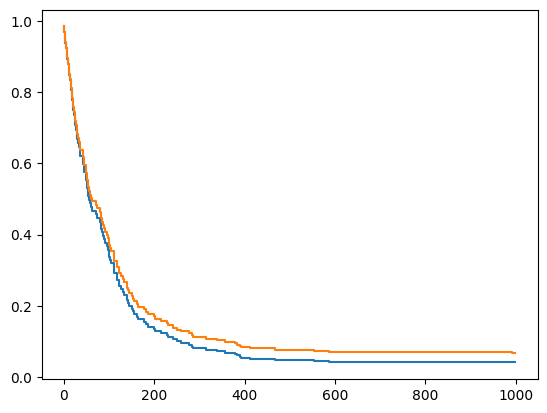

In [332]:
plt.step(np.unique(t_test2), bart_2_rr)
plt.step(np.unique(t_test2), b2_surv_mean3)

### BART3 Model
add in the offset

In [42]:
import scipy.stats as sp
# sp.qnorm(np.mean(delta2))
off = sp.norm.ppf(np.mean(delta2))
off

-2.037104634504509

In [13]:
with pm.Model() as bart3:
    x_data = pm.MutableData("x", trainx2)
    # y_data = pm.MutableData("y", delta1)
    
    f = pmb.BART("f", X = x_data, Y = delta2, m=100)
    z = pm.Deterministic("z", f + off)

    mu = pm.Deterministic("mu", pm.math.invprobit(z))
    y_pred = pm.Bernoulli("y_pred", p=(mu), observed=delta2, shape=x_data.shape[0])
    smp3 = pm.sample(random_seed=2, draws=100)

Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [f]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 268 seconds.
/home/twj8/.local/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [15]:
smp3

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [16]:
with bart3:
    pm.set_data({"x":testx2})
    pp3 = pm.sample_posterior_predictive(smp3, var_names= ["y_pred", "f", "z", "mu"])

Sampling: [f, y_pred]


In [19]:
pp3

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [26]:
def get_surv(posterior, KK, NN):
    shp = posterior.posterior_predictive["mu"].shape
    rows = shp[0]*shp[1]
    cols = shp[2]

    surv = 1-posterior.posterior_predictive["mu"].values
    survm = np.matrix(surv.reshape((rows, cols)))
   
    for h in range(0,NN):
        for j in range(1,KK):
            l = KK*h +j
            survm[:, l] = np.array(survm[:, l-1]) * np.array(survm[:,l])

    surv_mean = np.mean(survm, axis=0).reshape((NN,KK))
    surv_mean = np.array(np.mean(surv_mean, axis=0)).reshape(KK)
    return surv_mean


In [29]:
b3_surv = get_surv(posterior=pp3, KK=101, NN=137)
b3_surv

array([0.9865325 , 0.97277267, 0.95907453, 0.94478454, 0.93012314,
       0.91525559, 0.9005158 , 0.88598482, 0.87174947, 0.85728965,
       0.84339464, 0.8295141 , 0.81532627, 0.80139611, 0.78772384,
       0.77455452, 0.76151724, 0.74862588, 0.73598141, 0.72370089,
       0.71156309, 0.69960943, 0.68789534, 0.67645746, 0.66531662,
       0.65439107, 0.64354689, 0.63292425, 0.62221598, 0.61142867,
       0.60072647, 0.59002021, 0.57912175, 0.56815225, 0.55727278,
       0.54652153, 0.53604458, 0.52586218, 0.51596784, 0.50635945,
       0.49686678, 0.48737638, 0.47800235, 0.46875168, 0.45969431,
       0.45060832, 0.44129473, 0.43177526, 0.42219422, 0.41271178,
       0.40323459, 0.39382725, 0.38437072, 0.37480693, 0.36525393,
       0.35566914, 0.34611794, 0.33668917, 0.32718477, 0.31791375,
       0.30875648, 0.29980564, 0.29080879, 0.28181159, 0.27282416,
       0.26396852, 0.25500919, 0.24601103, 0.23721155, 0.22850448,
       0.21991106, 0.21131601, 0.20289955, 0.194554  , 0.18642

In [30]:
# b3_surv_mean = np.mean(b3_survm, axis=0).reshape((NN,KK))
# b3_surv_mean2 = np.array(np.mean(b3_surv_mean, axis=0)).reshape(KK)
# b3_surv_mean2

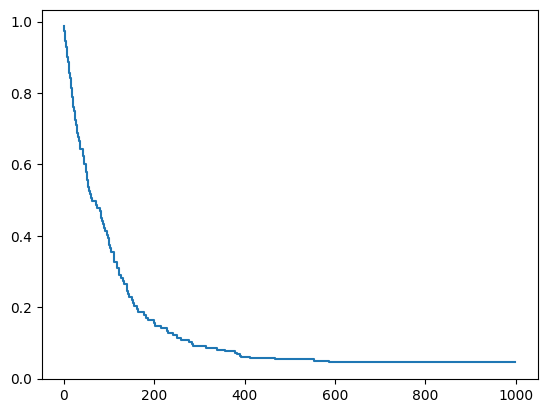

In [31]:
plt.step(np.unique(t_test2), b3_surv)

### Model BART 4

In [85]:
# trainx2.shape
# delta2.shape
# times2 = np.unique(trainx2[:,0], return_index=True, return_counts=True)
# freq = times2[2]
# freq

# try conditioning y to the z
# delta2

def get_z(delta):
    z = np.zeros(shape=delta.shape)
    for idx, i in enumerate(delta):
        # print(i)
        if i == 1:
            z[idx] = sp.truncnorm.rvs(0, np.Inf, size = 1)
        else:
            z[idx] = sp.truncnorm.rvs(np.NINF, 0, size = 1)
    return z



zdelt = get_z(delta2)
# print(zdelt[delta2==1])
# print(delta2[delta2==1])

[0.72734016 0.10118778 1.53559843 1.53214087 0.3927393  0.13144741
 2.22823009 0.03470337 0.45797701 0.04350599 1.2733321  0.01463039
 0.18676395 0.7724273  0.03607313 0.14425941 1.33269561 0.01815212
 0.57468927 0.15339431 0.94986166 0.32304936 1.33972444 0.48485003
 0.95442453 0.64489067 0.52388252 0.4601326  0.81725754 1.00063732
 1.0860797  0.75743851 2.10798116 0.18275515 1.19163852 0.15915278
 0.98389589 0.91302292 1.40356867 0.44281019 1.23901539 1.4290442
 0.30500394 1.24205431 3.69126538 1.36086401 0.35282676 0.19761136
 0.47901475 0.55761548 0.61232134 0.30372519 0.96436706 0.18363806
 0.60111823 0.67545139 0.21852132 1.29224751 0.89944721 0.27207901
 0.47214593 1.90623712 0.91325483 1.17211003 1.34954036 1.49247328
 1.52709343 0.34213599 0.36275887 1.29967075 0.13256547 0.16703331
 2.37402515 0.08174117 0.13654972 0.91512231 0.64562372 2.59622552
 0.90383699 0.54936648 0.43149264 0.12393108 0.67167728 0.44293371
 0.41719089 0.25264573 0.63975113 0.3756902  1.34255379 1.13094

In [97]:
# try with binomial
with pm.Model() as bart4:
    x_data = pm.MutableData("x", trainx2)
    # y_data = pm.MutableData("y", delta1)
    
    # f = pmb.BART("f", X = x_data, Y = zdelt, m=50)
    f = pmb.BART("f", X = x_data, Y = delta2, m=50)
    z = pm.Deterministic("z", f + off)

    mu = pm.Deterministic("mu", pm.math.invprobit(z))
    # y_pred = pm.Binomial("y_pred", p = mu, observed = delta2)
    y_pred = pm.Bernoulli("y_pred", p=(mu), observed=delta2, shape=x_data.shape[0])
    smp4 = pm.sample(random_seed=2, draws=1000)


Multiprocess sampling (4 chains in 4 jobs)
PGBART: [f]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 205 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [98]:
smp4

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [99]:
with bart4:
    pm.set_data({"x":testx2})
    pp4 = pm.sample_posterior_predictive(smp4, var_names= ["y_pred", "f", "z", "mu"])

Sampling: [f, y_pred]


In [100]:
pp4

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [101]:
b4_surv = get_surv(posterior=pp4, KK=101, NN=137)

In [102]:
b4_surv

array([0.98559768, 0.97150627, 0.9574906 , 0.94309395, 0.9281608 ,
       0.91310232, 0.89839569, 0.88396043, 0.86969734, 0.85562247,
       0.84168729, 0.82791661, 0.81409157, 0.80049345, 0.78708929,
       0.77388227, 0.7609052 , 0.74795207, 0.73514895, 0.72263931,
       0.71036708, 0.69833635, 0.68654456, 0.67510209, 0.66387962,
       0.6528556 , 0.64194526, 0.63119172, 0.62044438, 0.60968431,
       0.59888243, 0.5879893 , 0.57705904, 0.56613071, 0.55536379,
       0.54479045, 0.53441652, 0.5242459 , 0.51427983, 0.50441923,
       0.49466753, 0.48500591, 0.47541411, 0.46591894, 0.45652976,
       0.44716856, 0.43773336, 0.42831132, 0.41886008, 0.40939419,
       0.39996855, 0.39047857, 0.38099663, 0.37148987, 0.36198521,
       0.352453  , 0.34287226, 0.3333337 , 0.32389971, 0.31460612,
       0.30545827, 0.29647932, 0.28760237, 0.27872307, 0.26992056,
       0.26114493, 0.25242615, 0.24381764, 0.23525313, 0.22682052,
       0.21846647, 0.21017855, 0.20202783, 0.19401643, 0.18616

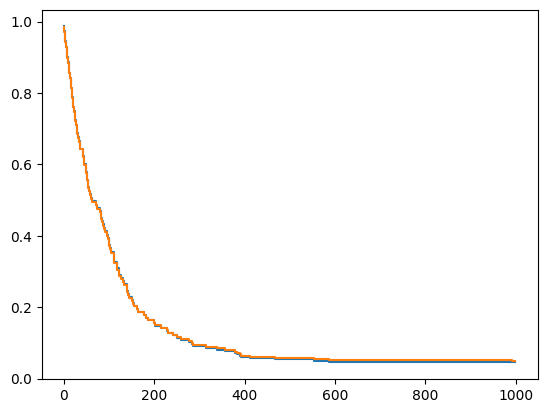

In [103]:
plt.step(np.unique(t_test2), b3_surv)
plt.step(np.unique(t_test2), b4_surv)

In [18]:
# with pm.Model() as bart4:
#     x_data = pm.MutableData("x", trainx2)
#     # y_data = pm.MutableData("y", delta1)
    
#     z = pmb.BART("z", X = x_data, Y = delta2)

#     mu = pm.Deterministic("mu", pm.math.invprobit(z + off))
#     # y_pred = pm.Bernoulli("y_pred", p=(mu), observed=delta2, shape=x_data.shape[0])
#     smp4 = pm.sample(random_seed=2, sample=100)

## Random Forest

In [33]:
import sksurv.ensemble

In [34]:
# set up random forest
rsf = sks.ensemble.RandomSurvivalForest(
    n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=20
)
rsf.fit(data_x_n, data_y)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=20)

In [35]:
rsf.score(data_x_n, data_y)

0.7402885052248978

In [36]:
rsf_surv1 = rsf.predict_survival_function(data_x_n, return_array=True)

In [37]:
rsf_surv_mean = np.mean(rsf_surv1,axis=0)
rsf_surv_mean

array([9.85286481e-01, 9.78087122e-01, 9.70833628e-01, 9.63436734e-01,
       9.41073764e-01, 9.11761915e-01, 8.97374085e-01, 8.90264614e-01,
       8.75527088e-01, 8.60685507e-01, 8.46475482e-01, 8.39587538e-01,
       8.18389056e-01, 8.04042404e-01, 7.89191001e-01, 7.74764260e-01,
       7.67337241e-01, 7.52866856e-01, 7.31300161e-01, 7.24201112e-01,
       7.17192869e-01, 7.02221637e-01, 6.86778672e-01, 6.79387927e-01,
       6.71937988e-01, 6.64197595e-01, 6.56607338e-01, 6.49070227e-01,
       6.41823041e-01, 6.34248661e-01, 6.27063119e-01, 6.19558336e-01,
       5.97302462e-01, 5.75378090e-01, 5.68247248e-01, 5.53615591e-01,
       5.46252200e-01, 5.39143426e-01, 5.31751345e-01, 5.24535959e-01,
       5.17159395e-01, 5.09501746e-01, 4.94906368e-01, 4.87582558e-01,
       4.87582558e-01, 4.79588937e-01, 4.71925713e-01, 4.64052013e-01,
       4.56181858e-01, 4.40968421e-01, 4.40968421e-01, 4.25191202e-01,
       4.17553959e-01, 4.10076792e-01, 4.02688593e-01, 3.94249444e-01,
      

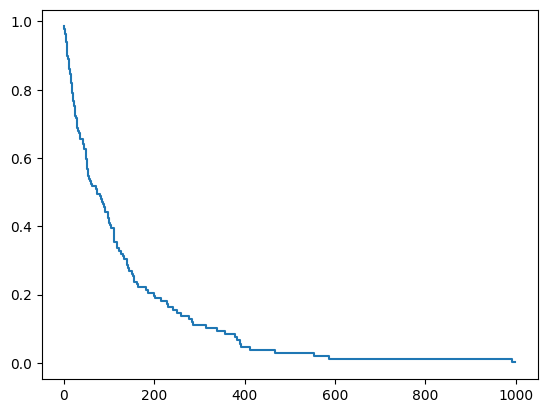

In [38]:
plt.step(np.unique(data_y["Survival_in_days"]), rsf_surv_mean, )

## Plot a few different models


In [39]:
kpm = sks.nonparametric.kaplan_meier_estimator(data_y["Status"], data_y["Survival_in_days"])

In [40]:
# get the rbart
rbart_mean = pd.read_csv("rbart_lung_mean.csv")
rbart_mean 

,Unnamed: 0,times,surv
0,1,1,0.979998
1,2,2,0.960956
2,3,3,0.942792
3,4,4,0.925434
4,5,7,0.908821
...,...,...,...
96,97,467,0.052426
97,98,553,0.043887
98,99,587,0.035863
99,100,991,0.029828


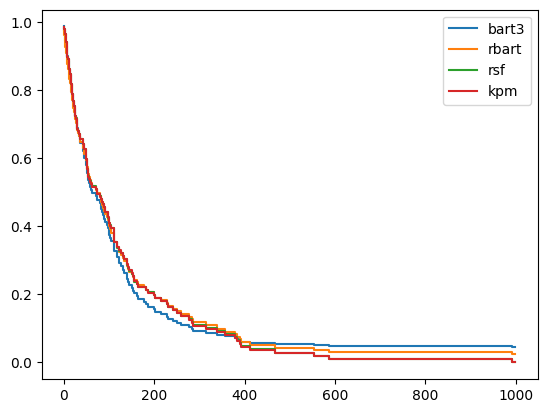

In [41]:
# plt.step(np.unique(t_test), bart_1_rr, label="bart")
# plt.step(np.unique(t_test2), bart_2_rr, label="bart2")
# plt.step(np.unique(t_test2), b2_surv_mean3, label="bart3")
plt.step(np.unique(t_test2), b3_surv, label="bart3")

plt.step(rbart_mean.times, rbart_mean.surv, label="rbart")
plt.step(np.unique(data_y["Survival_in_days"]), rsf_surv_mean, label = "rsf")
# plt.step(np.unique(data_y["Survival_in_days"]), cph_surv_mean, label="cph")
plt.step(kpm[0], kpm[1], label="kpm")
plt.legend(loc="best")


Right now there seems to be a little bit of bias in the the pymc bart implementations